Veri seti :
2 Mayıs 2020'den 16 Haziran 2022'ye kadar günlük (simüle edilmiş) sipariş sayısına sahibiz. Ayrıca sıcaklık ve pazarlama harcamalarına ilişkin veriler topladık.

Modeli her Pazartesi sabahı çalıştırmamız ve önümüzdeki 2 hafta için tahminler almamız gerekiyor. Sıcaklık sütunundaki değerlerin gerçek değerler olduğunu, dolayısıyla yalnızca mevcut ve geçmiş günler için geçerli olduğunu unutmayın. Öte yandan, pazarlama harcaması önceden bilebileceğimiz bir özellik olduğundan tahmin anında kullanılabilir.

Üstelik sadece nokta tahminleriyle değil, aynı zamanda tahminlerin belirsizliğiyle de ilgileniyoruz.
Bu modeli üretime koymadan önce model performansını değerlendirmemiz gerekiyor, bu nedenle lütfen numune dışı beklenen performans hakkında bilgi verin.

Gelecekteki meslektaşlarınızın bu ödevi değerlendireceğini unutmayın, bu nedenle şu şekilde değerlendirin: İncelenmeye hazır, iyi yapılandırılmış, takip edilmesi kolay, temiz kodlu, uygulanabilir olduğunda yorumlar/anlatımlar içeren bir çalışma. İade edilen rapor, düşünce sürecinizi açıklamaya ve gerekçenizi anlamamıza yardımcı olmaya yetecek kadar tartışma içermelidir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
#Csv Dosyasının okunması
df=pd.read_csv("data_-_train.csv",parse_dates=['date'],index_col='date').asfreq('D')
df


,orders,temperature,media_spend
date,,,
2020-05-02,54,18.270322,0.0
2020-05-03,63,19.882444,0.0
2020-05-04,56,16.878095,0.0
2020-05-05,65,21.878648,0.0
2020-05-06,64,21.112398,0.0
...,...,...,...
2022-06-12,76,11.472592,0.0
2022-06-13,78,NaN,0.0
2022-06-14,79,11.813969,0.0


In [3]:
#Verinin genel olarak kontrol edilmesi
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 776 entries, 2020-05-02 to 2022-06-16
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   orders       776 non-null    int64  
 1   temperature  756 non-null    float64
 2   media_spend  776 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 24.2 KB


In [4]:
df.shape

(776, 3)

In [5]:
# Target kolonu ile diğer kolonlar arasındaki korelasyonun gösterilmesi
df_corr=df[["orders","temperature","media_spend"]].corr(method='spearman')
df_corr
#Veriler ilk izlenimler sonucu normal dağıldığı için spearman kullanıldı.

,orders,temperature,media_spend
orders,1.000000,0.715629,0.199126
temperature,0.715629,1.000000,0.023737
media_spend,0.199126,0.023737,1.000000


In [6]:
# df_corr=df[["orders","temperature","media_spend"]].corr(method='pearson')
# print(df_corr)
      
# df_corr=df[["orders","temperature","media_spend"]].corr(method='kendall')
# print(df_corr)

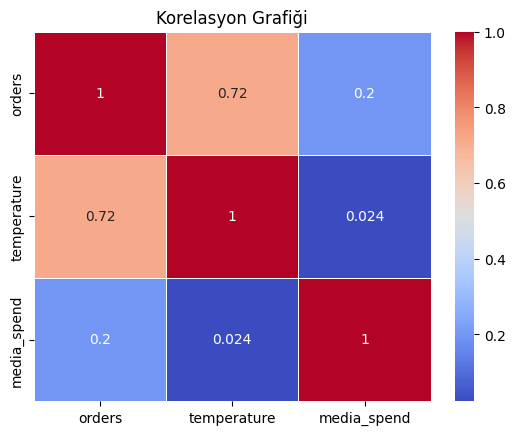

In [7]:
sns.heatmap(df_corr,annot=True,cmap="coolwarm",linewidths=.5)
plt.title("Korelasyon Grafiği")
plt.show()
# Grafikten anlaşılacağı gibi sipariş sayısının sıcaklık değeri ile bir ilgisi olduğu görünüyor.

In [8]:
# Eksik Verilerin kontrol edilmesi
df.isnull().sum()
#Görüldüğü üzere sıcaklık verisinde 20 null değer mevcut.

orders          0
temperature    20
media_spend     0
dtype: int64

Kayıp Değerlerin Ele Alınması

In [9]:
#NaN değerlerin interpolasyon metodu ile doldurulması
#Kayıp olmayan veriler doğrultusunda kayıp  verilerin doldurulmasıdır.(sıcaklık değerleri)
df["temperature"]=df["temperature"].interpolate()
df

,orders,temperature,media_spend
date,,,
2020-05-02,54,18.270322,0.0
2020-05-03,63,19.882444,0.0
2020-05-04,56,16.878095,0.0
2020-05-05,65,21.878648,0.0
2020-05-06,64,21.112398,0.0
...,...,...,...
2022-06-12,76,11.472592,0.0
2022-06-13,78,11.643281,0.0
2022-06-14,79,11.813969,0.0


Aykırı değerlerin(Outlier) Ele Alınması

<Figure size 640x480 with 0 Axes>

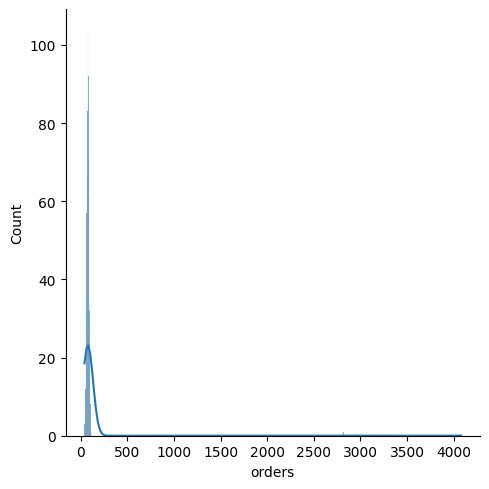

In [10]:
# Orders kolonunun kontrol edilmesi
plt.figure()
sns.displot(df["orders"],kde=True)
plt.show()

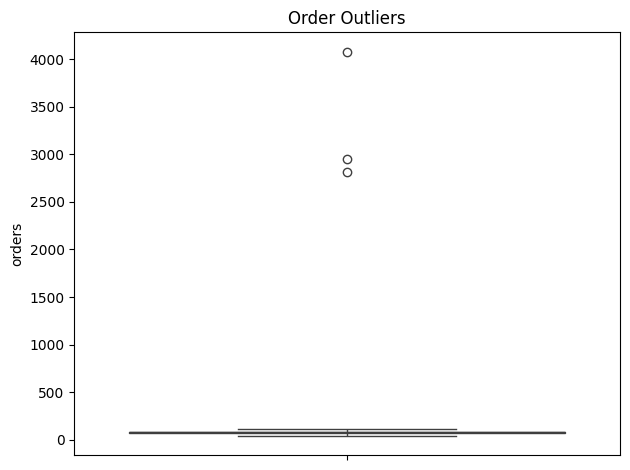

In [11]:
sns.boxplot(df["orders"])
plt.title("Order Outliers")
plt.tight_layout()
plt.show()
#Csv-2816,2952,4080

In [12]:
#Yukarıdaki dağılıma sebep olan değerleri göstermek için en büyük 3 değerin alınması
outlier_degerler=df["orders"].nlargest(5)
outlier_degerler
#İlk 3 değer ciddi anlamda normal dağılımı bozuyor.

date
2021-03-22    4080
2020-06-03    2952
2021-01-14    2816
2021-08-29     113
2021-10-27     111
Name: orders, dtype: int64

<Figure size 640x480 with 0 Axes>

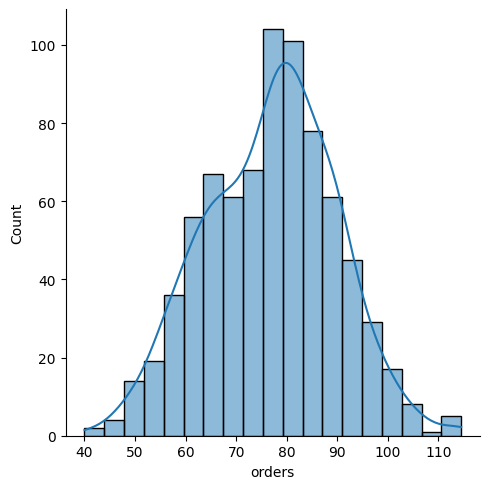

In [13]:
# Order sütununda görünen 3 outlier değerin baskılanması
for  col in df:
    Q1=df["orders"].quantile(0.25)
    Q3=df["orders"].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1-(IQR*1.5)
    upper=Q3+(IQR*1.5)
    df["orders"]=np.where(df["orders"]>upper,upper,np.where(df["orders"]<lower,lower,df['orders']))
plt.figure()
sns.displot(df["orders"],kde=True)
plt.show()
#Bir önceki grafiğe göre daha normal bir dağılım göstermektedir.

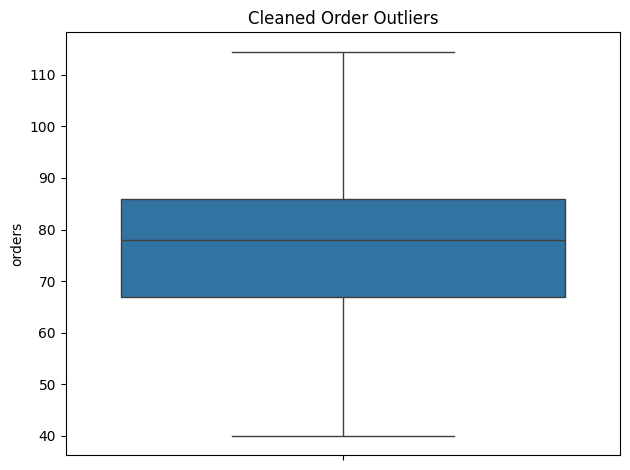

In [14]:
# Boxplot grafiği ile outlier değerlerin yeniden kontrolü
sns.boxplot(df["orders"])
plt.title("Cleaned Order Outliers")
plt.tight_layout()
plt.show()


In [15]:
print(upper)
print(lower)
#Üst limitin çok üzerinde olan 3 outlier değer(2816,2952,4080)baskılanarak üst sınır olan (114.5)değerlerine getirilir.

114.5
38.5


In [16]:
# Verinin Durağanlığının ölçülmesi
from statsmodels.tsa.stattools import adfuller
adf_test=adfuller(df["orders"])
p_value=adf_test[1]
p_value
#Sonuca bakacak olursak p_value>0.05 old. için veri durağan değildir.

0.09704356291983035

In [17]:
# SONUCU TEST ETME

# df2=pd.read_csv("data_-_train.csv",parse_dates=['date'],index_col='date').asfreq('D')
# df2['orders']=df2["orders"].interpolate
# adf_test=adfuller(df["orders"])
# p_value=adf_test[1]
# p_value

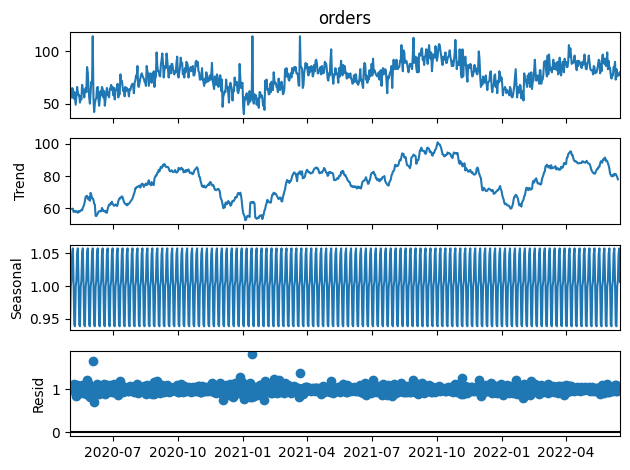

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_dec = seasonal_decompose(df["orders"], model="mull", period=7)
dec_plot = df_dec.plot()

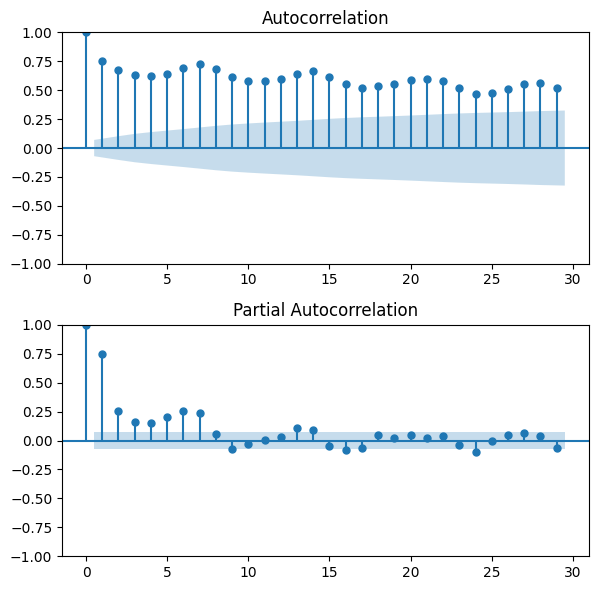

In [19]:
# ACF ve PACF Grafiklerinin Çizdirilmesi
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

# ACF grafiği
plot_acf(df["orders"], ax=axes[0])
axes[0].set_title('Autocorrelation')

# PACF grafiği
plot_pacf(df["orders"], ax=axes[1])
axes[1].set_title('Partial Autocorrelation')

plt.tight_layout()
plt.show()
#Acf grafiğinde bir mevsimsellik ve trend var denilebilir.

In [20]:
#Outlierlerin temizlenmesi sonucu durağan olmayan verimizin durağan hale gelmesi için fark alma(diff) işlemi yapıldı.
df1=df.copy()
df1["orders"] = df1["orders"].diff()

df1=df1.dropna()
 
df1


,orders,temperature,media_spend
date,,,
2020-05-03,9.0,19.882444,0.0
2020-05-04,-7.0,16.878095,0.0
2020-05-05,9.0,21.878648,0.0
2020-05-06,-1.0,21.112398,0.0
2020-05-07,-9.0,19.044652,0.0
...,...,...,...
2022-06-12,-7.0,11.472592,0.0
2022-06-13,2.0,11.643281,0.0
2022-06-14,1.0,11.813969,0.0


In [21]:
adf_test = adfuller(df1["orders"])
p_value = adf_test[1]
print(p_value)
#Fark alma işlemi ile birlikte veri durağan hale getirildi.

3.5804463721498136e-13


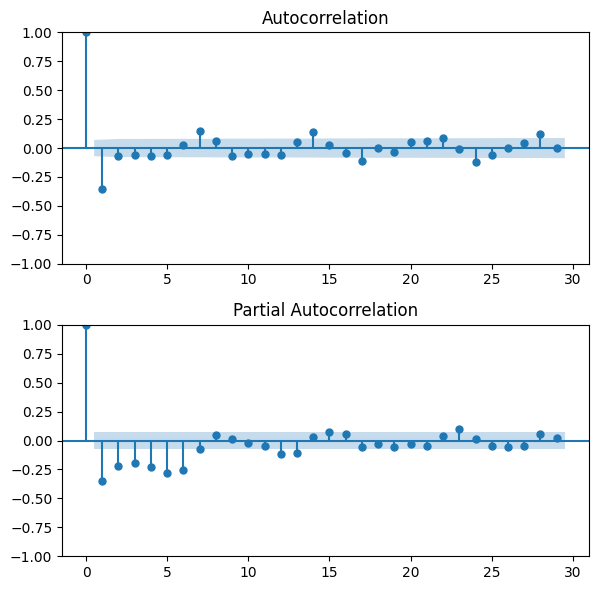

In [22]:
# Fark işleminin ardından yeniden ACF ve PACF grafiklerininiz çizilmesi

fig, axes = plt.subplots(2, 1, figsize=(6, 6))

# ACF grafiği
plot_acf(df1["orders"], ax=axes[0])
axes[0].set_title('Autocorrelation')

# PACF grafiği
plot_pacf(df1["orders"], ax=axes[1])
axes[1].set_title('Partial Autocorrelation')

plt.tight_layout()
plt.show()

In [23]:
# MODEL FİT EDİLİRKEN EXOG EKLENMESİ


# from statsmodels.tsa.arima.model import ARIMA
# model = ARIMA(df["orders"], order = (3,0,3), exog=df["temperature"] , trend="n")
# model_fit = model.fit()
# print(model_fit.summary())

In [24]:
# #Acf,Pacf lagleri ile oluşturulan deneme modeli

# from statsmodels.tsa.arima.model import ARIMA
# df2=df.copy()
# model=ARIMA(df2["orders"],order=(1,1,6),exog=df2["temperature"],seasonal_order=(1,0,6,7),trend="t")
# model_fit = model.fit()
# print(model_fit.summary())


In [25]:
import pymannkendall as mk
 
mk.original_test(df1["orders"])
#Kontrol etmek için veriye Mann-Kendall testi uygulandı.
#Test doğrultusunda trendin olmadığını h=false ile anladık.Olsaydı zaten trend kısmında türü de görünecekti.
#

Mann_Kendall_Test(trend='no trend', h=False, p=0.8996456867790097, z=-0.1261089451749648, Tau=-0.0030274235225473036, s=-908.0, var_s=51727654.666666664, slope=0.0, intercept=0.0)

In [26]:
# mk.original_test(df["orders"])
# Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=12.826860616187739, Tau=0.3075656800798138, s=92485.0, var_s=51986725.0, slope=0.026217228464419477, intercept=67.84082397003745)

In [27]:
adf_test = adfuller(df["temperature"])
p_value = adf_test[1]
print(p_value)
#Temperature değeri 0.05'ten büyük olduğu için durağan değildir. 

0.13178731632527196


In [28]:
df["temperature"]=df["temperature"].diff()


In [29]:
df=df.dropna()


In [30]:
adf_test = adfuller(df["temperature"])
p_value = adf_test[1]
print(p_value)
#Sıcaklık değeri durağan hale geldi.

0.0


In [31]:
# #Veriyi Train ve Set olarak Bölme

data_train,data_test=df[:-14],df[-14:]

#Train
# data_train=(df1.iloc[:-14])

# #Test Veriseti (Son 14 gün)
# data_test=(df1.iloc[-14:])
print(data_test)
#Test yapılacak son 14 günün verisi aşağıdaki gibidir.

            orders  temperature  media_spend
date                                        
2022-06-03    77.0     1.166438          0.0
2022-06-04    74.0    -5.463650          0.0
2022-06-05    78.0     3.769344          0.0
2022-06-06    77.0     1.758233          0.0
2022-06-07    85.0    -5.022199          0.0
2022-06-08    84.0     2.361692          0.0
2022-06-09    90.0     7.803964          0.0
2022-06-10    73.0    -8.792055          0.0
2022-06-11    83.0     9.441176          0.0
2022-06-12    76.0    -8.405038          0.0
2022-06-13    78.0     0.170688          0.0
2022-06-14    79.0     0.170688          0.0
2022-06-15    77.0    -1.703256          0.0
2022-06-16    80.0     0.881424          0.0


In [32]:
data_train
#Train verisine göz atmak için yazdırıldı

,orders,temperature,media_spend
date,,,
2020-05-03,63.0,1.612122,0.0
2020-05-04,56.0,-3.004349,0.0
2020-05-05,65.0,5.000553,0.0
2020-05-06,64.0,-0.766250,0.0
2020-05-07,55.0,-2.067746,0.0
...,...,...,...
2022-05-29,99.0,8.036367,0.0
2022-05-30,83.0,-11.870539,0.0
2022-05-31,91.0,2.962692,0.0


In [33]:

# import optuna
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# import itertools
# import pandas as pd
# import logging

# optuna.logging.set_verbosity(optuna.logging.ERROR)


# p = d = q = range(0, 4)
# pdq = list(itertools.product(p, d, q))
# pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))] 

# order_aic_bic = []
# def objective_sarima(trial):
#     order = trial.suggest_categorical('order', pdq)
#     seasonal_order = trial.suggest_categorical('seasonal_order', pdqs)
#     trend = trial.suggest_categorical('trend', ['n', 'c', 't', 'ct', None])
#     model = SARIMAX(data_train["orders"], exog=data_train["temperature"], order=order, seasonal_order=seasonal_order, trend=trend, initialization='approximate_diffuse')
#     mdl = model.fit(disp=0)
#     aic = mdl.aic
#     bic = mdl.bic
#     order_aic_bic.append((order, seasonal_order, trend, aic, bic))

# study = optuna.create_study(direction="minimize")
# study.optimize(objective_sarima, n_trials=50)

# order_df = pd.DataFrame(order_aic_bic, columns=["order", "seasonal_order", "trend", "AIC", "BIC"])
# print(order_df.sort_values("AIC").head(3))
# print(order_df.sort_values("BIC").head(3))

In [34]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

order_aic_bic = []
for p in range(0, 2):
    for q in range(0, 2):
        for P in range(0, 2):
            for Q in range(0, 2):
                for d in range(0,2):
                    for D in range(0,2):
                        for trend in ["t", "n", "c", "ct"]:
                            model = SARIMAX(data_train["orders"],exog=data_train["temperature"], order=(p, d, q), seasonal_order=(P, D, Q, 7))
                            model_fit = model.fit(disp=0)
                            aic = model_fit.aic
                            bic = model_fit.bic
                            order_aic_bic.append((p, d, q, P, D, Q, trend, aic, bic))
                
order_df = pd.DataFrame(order_aic_bic, columns=["p", "q", "d", "P", "D", "Q", "trend", "AIC", "BIC"])
print(order_df.sort_values("AIC").head(3))
print(order_df.sort_values("BIC").head(3))

     p  q  d  P  D  Q trend          AIC          BIC
255  1  1  1  1  1  1    ct  4992.433476  5020.177867
253  1  1  1  1  1  1     n  4992.433476  5020.177867
252  1  1  1  1  1  1     t  4992.433476  5020.177867
     p  q  d  P  D  Q trend          AIC          BIC
223  1  1  1  0  1  1    ct  4992.541486  5015.661812
222  1  1  1  0  1  1     c  4992.541486  5015.661812
221  1  1  1  0  1  1     n  4992.541486  5015.661812


In [35]:
# !!! Modelde durağan sıcaklık değerini ver, buradaki değer durağan değil

In [47]:
# Modeli oluştur
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(data_train["orders"], order=(1,1,1), seasonal_order=(1, 1, 1, 7) , trend="n",exog=data_train["temperature"]) #??

# Modeli eğit              
model_fit = model.fit(disp=0)

# Tahminleri yap
fitted = model_fit.predict()

# Fit edilen modelin hata payı
resids = model_fit.resid

# Tahminlerin traine eklenmesi

data_train.loc[:,"fitted"] = fitted


In [48]:
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            orders   No. Observations:                  761
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2490.217
Date:                           Fri, 09 Feb 2024   AIC                           4992.433
Time:                                   21:39:21   BIC                           5020.178
Sample:                               05-03-2020   HQIC                          5003.122
                                    - 06-02-2022                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     0.4773      0.043     11.082      0.000       0.393       0.562
ar.L1           0.1935      0.034      5

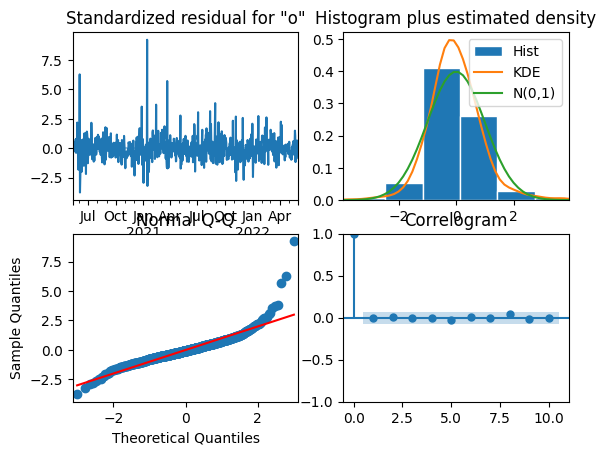

In [49]:
# SARIMAX ile elde edilen modelin görselleştirilmesi
model_fit.plot_diagnostics()

plt.show()

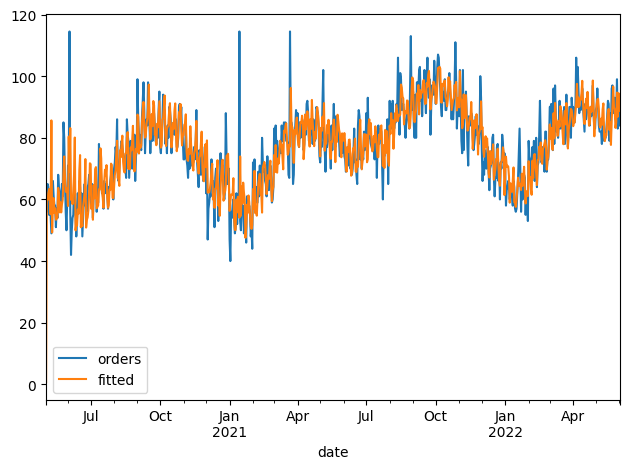

In [50]:
# Orders ile tahminlerin çizdirilmesi
data_train[["orders","fitted"]].plot()
plt.tight_layout()
plt.show()

Test Verilerinin Tahmini

In [51]:
# Test verisi üzerinde tahmin yapma ve exog değerini ekleyerek

test_predicted = model_fit.forecast(steps=len(data_test), exog=df["temperature"][data_test.index].values)

# # Tahmin edilen değerleri ve gerçek değerleri karşılaştırma
# plt.plot(data_test.index, data_test, label='Gerçek Değerler')
# plt.plot(data_test.index, test_predicted, color='red', linestyle='--', label='Tahmin Edilen Değerler')
# plt.xlabel('Zaman')
# plt.ylabel('Değerler')
# plt.title('Gerçek ve Tahmin Edilen Değerler')
# plt.legend()
# plt.show()

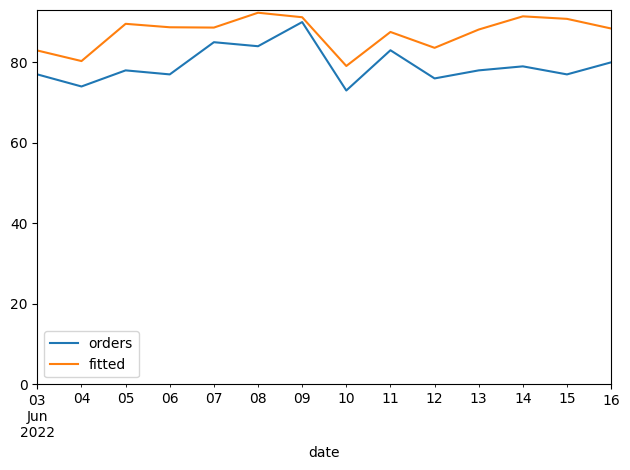

In [58]:
data_test.loc[:,"fitted"] = test_predicted

data_test[["orders","fitted"]].plot()
plt.ylim(0,93)
plt.tight_layout()
plt.show()

Değerlendirme ( MSE,MEA,RSME )

In [53]:
# train verisi için; 
print("TRAIN")
mae = np.mean(np.abs(resids.values))
mse = np.mean(np.square(resids.values))
rmse = np.sqrt(np.mean(np.square(resids.values)))
print("MAE :",mae)
print("MSE :",mse)
print("RMSE :",rmse)

print()

# test verisi için;
print("TEST")
mae = np.mean(np.abs(data_test["orders"]-test_predicted))
mse = np.mean(np.square(data_test["orders"]-test_predicted))
rmse = np.sqrt(np.mean(np.square(data_test["orders"]-test_predicted)))
print("MAE :",mae)
print("MSE :",mse)
print("RMSE :",rmse)
#bu değerler doğrultusunda overfit yok debilebilir.

TRAIN
MAE : 4.674975223186204
MSE : 50.71505304984347
RMSE : 7.121450206934222

TEST
MAE : 7.977666284249862
MSE : 75.9777262223611
RMSE : 8.716520304706522


UNSEEN İLE TAHMİN YAPMA

In [69]:
unseen=pd.read_csv("data_-_unseen_features.csv")
unseen

,date,temperature,media_spend
0,2022-06-17,11.923126,0.000000
1,2022-06-18,14.986238,0.000000
2,2022-06-19,11.003947,0.000000
3,2022-06-20,12.699259,0.000000
4,2022-06-21,17.852300,0.000000
5,2022-06-22,11.601299,0.000000
6,2022-06-23,16.207998,14.847883
7,2022-06-24,12.952067,0.000000
8,2022-06-25,9.284319,14.664207
9,2022-06-26,12.669216,0.000000


In [70]:
unseen["temperature"]=unseen["temperature"].interpolate()
unseen


,date,temperature,media_spend
0,2022-06-17,11.923126,0.000000
1,2022-06-18,14.986238,0.000000
2,2022-06-19,11.003947,0.000000
3,2022-06-20,12.699259,0.000000
4,2022-06-21,17.852300,0.000000
5,2022-06-22,11.601299,0.000000
6,2022-06-23,16.207998,14.847883
7,2022-06-24,12.952067,0.000000
8,2022-06-25,9.284319,14.664207
9,2022-06-26,12.669216,0.000000


In [71]:
#
adf_test=adfuller(unseen["temperature"])
p_value=adf_test[1]
p_value
#Unseen datamızın sıcaklık değeri durağan değil.

0.616978652504018

In [72]:
df_data = pd.read_csv("data_-_train.csv")
df_data.head()

,date,orders,temperature,media_spend
0,2020-05-02,54,18.270322,0.0
1,2020-05-03,63,19.882444,0.0
2,2020-05-04,56,16.878095,0.0
3,2020-05-05,65,21.878648,0.0
4,2020-05-06,64,21.112398,0.0


In [73]:
df_data.shape

(776, 4)

In [74]:
df_data = df_data.drop(columns="orders")
df_data.head(3)

,date,temperature,media_spend
0,2020-05-02,18.270322,0.0
1,2020-05-03,19.882444,0.0
2,2020-05-04,16.878095,0.0


In [75]:
df_unseen=pd.concat([df_data,unseen],axis=0)
df_unseen

,date,temperature,media_spend
0,2020-05-02,18.270322,0.0
1,2020-05-03,19.882444,0.0
2,2020-05-04,16.878095,0.0
3,2020-05-05,21.878648,0.0
4,2020-05-06,21.112398,0.0
...,...,...,...
9,2022-06-26,12.669216,0.0
10,2022-06-27,9.819516,0.0
11,2022-06-28,18.834372,0.0
12,2022-06-29,15.408380,0.0


In [76]:
df_unseen.isnull().sum()

date            0
temperature    20
media_spend     0
dtype: int64

In [77]:
df_unseen["temperature"] = df_unseen["temperature"].interpolate()

In [78]:
df_unseen.isnull().sum()
# NaN değer kalmadı

date           0
temperature    0
media_spend    0
dtype: int64

In [79]:
# date sutununu datetime ve index haline dönüştür
df_unseen['date'] = pd.to_datetime(df_unseen['date'])
df_unseen.set_index('date', inplace=True)

In [81]:
df_unseen

,temperature,media_spend
date,,
2020-05-02,18.270322,0.0
2020-05-03,19.882444,0.0
2020-05-04,16.878095,0.0
2020-05-05,21.878648,0.0
2020-05-06,21.112398,0.0
...,...,...
2022-06-26,12.669216,0.0
2022-06-27,9.819516,0.0
2022-06-28,18.834372,0.0


In [82]:
adf_test = adfuller(df_unseen["temperature"])
p_value = adf_test[1]
print(p_value)

0.11821973696280547


In [83]:
df_unseen["temperature"]=df_unseen["temperature"].diff()
df_unseen=df_unseen.dropna()

In [84]:
adf_test = adfuller(df_unseen["temperature"])
p_value = adf_test[1]
print(p_value)
#Durağan hale geldi.

0.0


In [85]:
unsenn = df_unseen.iloc[-14:]
unsenn

,temperature,media_spend
date,,
2022-06-17,0.930988,0.000000
2022-06-18,3.063113,0.000000
2022-06-19,-3.982292,0.000000
2022-06-20,1.695313,0.000000
2022-06-21,5.153040,0.000000
2022-06-22,-6.251000,0.000000
2022-06-23,4.606699,14.847883
2022-06-24,-3.255931,0.000000
2022-06-25,-3.667748,14.664207


In [45]:
# Temperature değeri interpolate edilerek verilecek

In [87]:
model = SARIMAX(df["orders"], order=(1,1,1), seasonal_order=(1, 1, 1, 7) , trend="n",exog=df["temperature"])
model_fit=model.fit(disp=0)
forecasts = model_fit.get_forecast(steps=len(unseen), exog=unseen["temperature"])

tahmin_değerleri = forecasts.predicted_mean
tahmin_değerleri

2022-06-17    80.716252
2022-06-18    81.951748
2022-06-19    84.333358
2022-06-20    85.345344
2022-06-21    91.058119
2022-06-22    88.167607
2022-06-23    87.323251
2022-06-24    81.238152
2022-06-25    79.137312
2022-06-26    85.174457
2022-06-27    84.138073
2022-06-28    91.813965
2022-06-29    90.335690
2022-06-30    85.400795
Freq: D, Name: predicted_mean, dtype: float64

Datadaki temp değeri ile

In [88]:
# df_unseen DataFrame'i oluşturma
df_unseen = pd.DataFrame(data=tahmin_değerleri)

# 'ORDERS' sütun adını değiştirme
df_unseen = df_unseen.rename(columns={"predicted_mean": "orders"})


# 'date' adında bir sütun olarak index'i kullanma
df_unseen['date'] = df_unseen.index

# kolonların yerini değiştir
df_unseen = df_unseen[["date","orders"]]

# Index sütununu sıfırdan başlatma
df_unseen.reset_index(drop=True, inplace=True)


# Veri çerçevesini yazdırma
df_unseen.head(14)


,date,orders
0,2022-06-17,80.716252
1,2022-06-18,81.951748
2,2022-06-19,84.333358
3,2022-06-20,85.345344
4,2022-06-21,91.058119
5,2022-06-22,88.167607
6,2022-06-23,87.323251
7,2022-06-24,81.238152
8,2022-06-25,79.137312
9,2022-06-26,85.174457


CSV OLARAK KAYDETME

In [89]:
df_unseen.to_csv('sample_submission.csv', index=False)